# Pricing simulations around product classes
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/pricing-simulations-around-product-classes/main.ipynb)._]

For more information on the classification algorithm and a high-level overview of this notebook, [check out our article on atoti.io](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).

## Introduction

In this notebook, we will showcase a simplified example of how a retailer can achieve a better price perception from its customers, while keeping or even slightly increasing its margins.

## Classification algorithm

With 3 months worth of receipts, we aim to classify the products into three categories:
- Driver products: Those are products that make people come to the store, their price is often compared to the competition. A typical example would be a drill. 
- Complementary products: Those are products that people do not intend to buy before coming to the store, they generate so called "opportunity" sales. Their price is most of the time not known. Examples are drill batteries or chewing gums near the checkout area.
- Independent products: This third group of products contains products that are often sold alone. They tend to be large and more expensive and thus also have a tendency to be compared.  

In order to do so, we derived the below values beforehand to help us with the classification:
- __solo_sales_ratio__: product's tendancy to be sold primarily alone. It's the ratio between the number of times the product as sold alone and the total number of sales of this product
- __product_receipt_score__: product scoring computed by counting the number of neighbors (products in the same receipt) with a lower scoring on the _solo_sales_ratio_, and dividing it by the total number of neighbors.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=pricing-simulation" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

In [1]:
# Install matplotlib and sklearn by running this code

# ! pip install matplotlib sklearn

In [2]:
import pandas as pd

Let's have a look at the products and their scoring based on what we have gathered from the receipts. 

In [3]:
df_product_score = pd.read_csv(
    "https://data.atoti.io/notebooks/products-classification/products_scoring.csv"
)
df_product_score.head()

,ProductId,edge_purchases,n_purchases,solo_purchases,solo_sales_ratio,product_receipt_score
0,67130910,66.0,141.0,75.0,0.531915,0.974194
1,67901421,523.0,1021.0,212.0,0.208046,0.797941
2,70645722,766.0,919.0,153.0,0.166485,0.223958
3,70748454,498.0,794.0,233.0,0.293756,0.372562
4,82008925,3836.0,5281.0,1445.0,0.273622,0.676743


#### Product classification with K-Means

Let's extract the features which we are going to apply [K-means](https://en.wikipedia.org/wiki/K-means_clustering) on in order to obtain the classifications.

In [4]:
df_classification = df_product_score[
    ["ProductId", "solo_sales_ratio", "product_receipt_score"]
].copy()

# ProductId is needed to reconcile the products and its classification
df_classification.set_index("ProductId", inplace=True)
df_classification.head()

,solo_sales_ratio,product_receipt_score
ProductId,,
67130910,0.531915,0.974194
67901421,0.208046,0.797941
70645722,0.166485,0.223958
70748454,0.293756,0.372562
82008925,0.273622,0.676743


As mentioned earlier, we needed 3 clusters - driver, complementary and independent.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_classification)
results = kmeans.predict(df_classification)

The below plot shows the result of the K-means clustering.

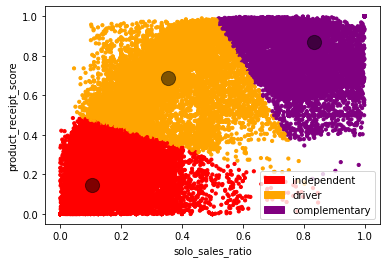

In [6]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

colormap = np.array(["orange", "red", "purple"])

data_to_plot = df_classification.to_numpy()
fig = plt.figure()
ax = plt.axes()
ax.scatter(
    data_to_plot[:, 0], data_to_plot[:, 1], c=colormap[results], s=10, cmap="viridis"
)
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)
cluster_1 = mpatches.Patch(color="red", label="independent")
cluster_2 = mpatches.Patch(color="orange", label="driver")
cluster_3 = mpatches.Patch(color="purple", label="complementary")
plt.legend(handles=[cluster_1, cluster_2, cluster_3])
ax.set_xlabel("solo_sales_ratio")
ax.set_ylabel("product_receipt_score")

plt.show()

Let's set the result back into the dataset to see the product classification.

In [7]:
df_classification["class"] = results

Since independent products are products that are most frequently sold by itself, its _solo_sales_ratio_ tends towards 1. Therefore, it is also most likely that the rest of the products in the same receipt have lower _solo_sales_ratio_. We can then infer that independent products have _product_receipt_score_ towards 1 as well.  

As we see below, class 1 is likely to be the independent products.

In [8]:
df_classification.loc[(df_classification["product_receipt_score"] > 0.5)].sort_values(
    by=["product_receipt_score"], ascending=False
).head(5)

,solo_sales_ratio,product_receipt_score,class
ProductId,,,
69395571,1.0,1.0,2
73245802,1.0,1.0,2
70854014,1.0,1.0,2
82054056,1.0,1.0,2
80139942,1.0,1.0,2


Since complementary products are usually brought alongside the driver products, its _solo_sales_ratio_ tends towards 0. Its _solo_sales_ratio_ would probably be the lowest since its _solo_sales_ratio_ would normally be lower than the other two product categories.  

Class 2 below is most likely complementary products. Therefore class 0 is the driver products.  
This could be explained by the fact that driver products have a higher likelihood of being sold alone compared to complementary products, so its _solo_sales_ratio_ theoretically would be lesser than independent products but higher than complementary products. The same implies for its _product_receipt_score_ since it probably has more products (the complementary) in the same receipt that have lower _solo_sales_ratio_ than itself.

In [9]:
df_classification.loc[(df_classification["product_receipt_score"] < 0.5)].sort_values(
    by=["product_receipt_score"]
).head(5)

,solo_sales_ratio,product_receipt_score,class
ProductId,,,
62024851,0.0,0.0,1
69313125,0.0,0.0,1
69311522,0.0,0.0,1
66786293,0.0,0.0,1
70679595,0.0,0.0,1


Let's map the class to its classification labels:

In [10]:
df_classification.loc[df_classification["class"] == 0, "Product Class"] = "Driver"
df_classification.loc[df_classification["class"] == 1, "Product Class"] = "Independent"
df_classification.loc[
    df_classification["class"] == 2, "Product Class"
] = "Complementary"

In [11]:
df_product_classification = pd.merge(
    df_product_score,
    df_classification[["Product Class", "class"]].reset_index(),
    left_on="ProductId",
    right_on="ProductId",
)

df_product_classification["ProductId"] = df_product_classification["ProductId"].astype(
    np.int64
)

df_product_classification.head()

,ProductId,edge_purchases,n_purchases,solo_purchases,solo_sales_ratio,product_receipt_score,Product Class,class
0,67130910,66.0,141.0,75.0,0.531915,0.974194,Complementary,2
1,67901421,523.0,1021.0,212.0,0.208046,0.797941,Driver,0
2,70645722,766.0,919.0,153.0,0.166485,0.223958,Independent,1
3,70748454,498.0,794.0,233.0,0.293756,0.372562,Independent,1
4,82008925,3836.0,5281.0,1445.0,0.273622,0.676743,Driver,0


## Importing atoti, having a first look at the data

First we will start atoti, load the products referential and have a look at the classification algorithm result on our dataset.

In [12]:
import atoti as tt

session = tt.Session(user_content_storage="./content", port=1111)

Loading the products referential with all the products information

In [13]:
products_table = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/products_referential.csv",
    keys=["ProductId"],
    table_name="Products",
)
products_table.head()

,Product Name,Brand
ProductId,,
69979833,Product 69979833,Brand 60029235
67130910,Product 67130910,Brand 80105193
70049084,Product 70049084,Brand 66825570
67901421,Product 67901421,Brand 81888450
58878995,Product 58878995,Brand 70698866


In [14]:
# print shape of table
{"columns": len(products_table.columns), "rows": len(products_table)}

{'columns': 3, 'rows': 58786}

Then loading the result of the classification algorithm

In [15]:
classified_products_table = session.read_pandas(
    df_product_classification, keys=["ProductId"], table_name="classified_products"
)
classified_products_table.head()

,edge_purchases,n_purchases,solo_purchases,solo_sales_ratio,product_receipt_score,Product Class,class
ProductId,,,,,,,
67130910,66.0,141.0,75.0,0.531915,0.974194,Complementary,2
67901421,523.0,1021.0,212.0,0.208046,0.797941,Driver,0
70645722,766.0,919.0,153.0,0.166485,0.223958,Independent,1
70748454,498.0,794.0,233.0,0.293756,0.372562,Independent,1
82008925,3836.0,5281.0,1445.0,0.273622,0.676743,Driver,0


And join them together

In [16]:
classified_products_table.join(products_table, mapping={"ProductId": "ProductId"})

We can then create a cube

In [17]:
cube = session.create_cube(classified_products_table, "products_cube")

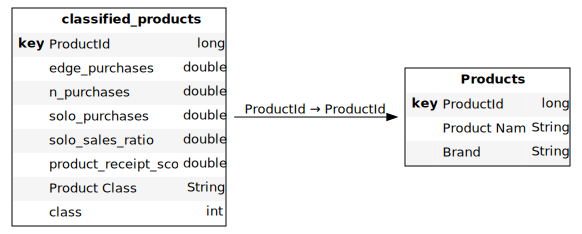

In [18]:
cube.schema

And have a first look at the data

In [19]:
session.visualize("Percentage of products per class pie chart")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [20]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Computing the margin

To perform that calculation we will load the purchase and selling prices tables and join them to the current data structure.

In [21]:
purchase_prices_table = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/purchase_prices.csv",
    keys=["ProductId"],
    table_name="purchase_prices",
)
purchase_prices_table.head()

,PurchasePrice
ProductId,
67130910,231.68
67901421,176.91
70645722,10.90
70748454,39.89
82008925,174.29


In [22]:
selling_prices_table = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/selling_prices.csv",
    keys=["ProductId"],
    table_name="selling_prices",
)
selling_prices_table.head()

,SellingPrice
ProductId,
67130910,338.97
67901421,234.04
70645722,15.68
70748454,59.42
82008925,253.33


In [23]:
classified_products_table.join(
    purchase_prices_table, mapping={"ProductId": "ProductId"}
)
classified_products_table.join(selling_prices_table, mapping={"ProductId": "ProductId"})

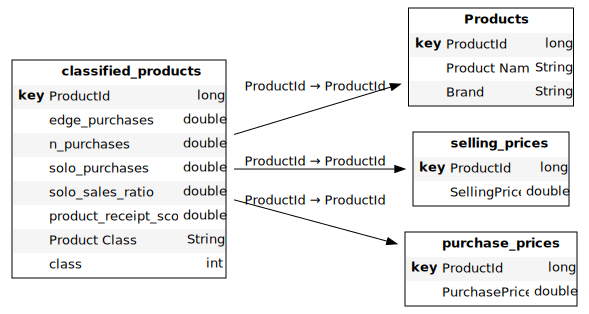

In [24]:
cube.schema

Let's now add the margin measure

In [25]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

In [26]:
cube

Cube(_name='products_cube', _hierarchies=Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of ...>, _cube_name='products_cube'), _measures=Measures())

Because selling and purchase prices are different per products, we have to compute the margin at ProductId level using parameter "scope", and then aggregate it as a sum above this level:

$\sum_{p \in Products}{(Selling Price - Purchase Price) \times Quantity Sold}$

In [27]:
m["SellingPrice.VALUE"] = tt.value(selling_prices_table["SellingPrice"])
m["PurchasePrice.VALUE"] = tt.value(purchase_prices_table["PurchasePrice"])
m["num_purchase"] = tt.value(classified_products_table["n_purchases"])

m["Margin.SUM"] = tt.agg.sum(
    (m["SellingPrice.VALUE"] - m["PurchasePrice.VALUE"]) * m["num_purchase"],
    scope=tt.scope.origin(lvl["ProductId"]),
)

In [28]:
session.visualize("Margin per product class")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

atoti visualizations are available both in the notebook, but also from the dedicated application.  
Run the two cells below to get a link to a summary dashboard of all what was done so far.

In [29]:
m["SellingPrice.MEAN"] = tt.agg.mean(
    m["SellingPrice.VALUE"], scope=tt.scope.origin(lvl["ProductId"])
)

m["PurchasePrice.MEAN"] = tt.agg.mean(
    m["PurchasePrice.VALUE"], scope=tt.scope.origin(lvl["ProductId"])
)

In [30]:
session.link(path="/#/dashboard/326")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

If you wish to play with the UI and explore the data by yourself, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Custom hierarchy

In [31]:
h["Products"] = {
    "Product Brand": lvl["Brand"],
    "Product Label": lvl["Product Name"],
}

In [32]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Computing the price index

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the competitors, measuring at which percentage of this average competitors price the product is.  

We will weight the price index indicator by the margin when aggregating above product level so that we later optimize the price index for products that contribute the most to our margin.  
Other commonly used formulas weight by sales quantity or revenue.

### Price Index Formula

# $100 \times \frac{\sum_{p \in Products}\frac{Selling Price(p)}{Average Competitor Price(p)} \times Margin(p)}{\sum_{p \in Products}Margin(p)}$

### Loading Competitor prices data

In [33]:
competitor_prices_table = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/competitor_prices.csv",
    keys=["ProductId", "CompetitorName"],
    table_name="Competitor_prices",
)

In [34]:
classified_products_table.join(
    competitor_prices_table, mapping={"ProductId": "ProductId"}
)

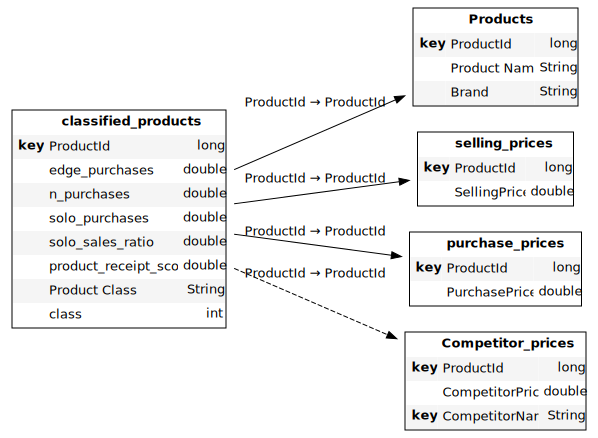

In [35]:
cube.schema

### Creating the price index measure

The "scope" parameters enables you to have a different aggregation strategy below the "on" level.  
In the following cell, everything above Product (ProductId) level is aggregated as a sum, while below the product level we find the previous formula, that does an average on the competitor prices just for one particular product.

In [36]:
m["CompetitorPrice.VALUE"] = tt.value(competitor_prices_table["CompetitorPrice"])
m["CompetitorPrice.MEAN"] = tt.agg.mean(m["CompetitorPrice.VALUE"])

In [37]:
price_index_numerator = tt.agg.sum(
    (m["SellingPrice.MEAN"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"]),
)

# Some products have no competitor price or selling price.
# We exclude them from the denominator for consistency with the numerator
price_index_denominator = tt.agg.sum(
    tt.where(
        (m["CompetitorPrice.MEAN"] != None) & (m["SellingPrice.MEAN"] != None),
        m["Margin.SUM"],
    ),
    scope=tt.scope.origin(lvl["ProductId"]),
)

In [38]:
m["Price Index"] = 100 * price_index_numerator / price_index_denominator

The price index measure is now created accordingly to the formula.

We can see below that our driver products are in fact a bit more expensive than the average market price while we are quite competitive on the complementary products, which is the opposite of our goal.

In [39]:
session.visualize("Price index per competitor")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Simulate Price Strategies

Complementary products are usually less expensive than those of the other two categories and people tend to ignore their price. This means that an increase in price does not necessarily mean a drop in sales.  

### Parameter simulation

In a first simulation we will try to assess how much margin we can make if we increase their price by 10%.

To do this we create a simulation against Class and ProductId levels and specify that we need to multiply by 1.1 each selling price. All KPIs defined previously such as the price index will be re-computed on the fly which will enable us to compare scenarios and their benefits.

In [40]:
price_strategies = cube.create_parameter_simulation(
    "Price Strategies",
    measures={"Selling price parameter": 1.0},
    levels=[lvl["Product Class"], lvl["ProductId"]],
)

Let's create a measure `Selling price` that scales the `SellingPrice.VALUE` by `Selling price parameter`. 

In [41]:
m["Selling price"] = m["SellingPrice.VALUE"] * m["Selling price parameter"]

Thereafter, let's update the definition of the `Margin.SUM`, `SellingPrice.MEAN` and `PurchasePrice.MEAN` with this new measure instead of `SellingPrice.VALUE`.

In [42]:
m["Margin.SUM"] = tt.agg.sum(
    (m["Selling price"] - m["PurchasePrice.VALUE"]) * m["num_purchase"],
    scope=tt.scope.origin(lvl["ProductId"]),
)

m["SellingPrice.MEAN"] = tt.agg.mean(
    m["Selling price"], scope=tt.scope.origin(lvl["ProductId"])
)

m["PurchasePrice.MEAN"] = tt.agg.mean(
    m["Selling price"], scope=tt.scope.origin(lvl["ProductId"])
)

Below is a scenario named `10% complementary increase`. By providing a value of "None" to the `ProductId` parameter implies that under the `Product Class`, all the "Complementary" products will have its selling price multiplied by the `Selling price parameter` of value "1.1".

In [43]:
price_strategies += ("10% complementary increase", "Complementary", None, 1.1)

We can see below that this represents a gain of 203 million per year, while increasing the index dramatically from 99.49 to 109.44.

In [44]:
session.visualize("Comparison of the two scenarios per product class")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Refer to the atoti documentation for more information on [Parameter simulation](https://docs.atoti.io/latest/tutorial/tutorial.html#Parameter-simulations).

### Source Simulation

As seen before a better strategy is to improve the price image by being more competitive on the driver and independent products, hence lowering the prices of those products, while compensating the losses in margin by increasing the prices of the complementary products.

We will first import our pricing methods: in this example a very simple pricing functions from our `pricer.py` file.

In [45]:
from price_engine import pricer

#### Extracting data from cube with query
Let's export the initial selling price and product classification from the cube into a Pandas dataframe:

In [46]:
initial_price_list_with_classes = cube.query(
    m["SellingPrice.VALUE"],
    levels=[
        lvl["ProductId"],
        lvl["Product Class"],
    ],
)
initial_price_list_with_classes.head()

,,SellingPrice.VALUE
ProductId,Product Class,
3003,Complementary,443.73
3031,Driver,344.72
3052,Independent,135.98
10395,Driver,302.53
10402,Driver,98.65


We will then give our initial price list to a price optimizer that will optimize prices and load the resulting price list into a third scenario named "Optimized price index" that we will be able to compare to the other scenarios.

In [47]:
initial_price_list_with_classes.reset_index(inplace=True)

In [48]:
selling_prices_for_optimized_price_index = pricer.optimize_price_index(
    initial_price_list_with_classes
)

In [49]:
selling_prices_table.scenarios["Optimized price index"].load_pandas(
    selling_prices_for_optimized_price_index
)

The result as we can see below is much better since we have been able to very slightly increase our global margin, while being much more competitive on the Driver products

In [50]:
session.visualize("Results summary")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Combining Scenarios

In [51]:
session.visualize("Price index comparison across scenarios (per class)")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

You can also have a look at our second summary dashboard of the simulation part (run the next cell to get the link)

In [52]:
session.link(path="/#/dashboard/781")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=pricing-simulation" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>